<a href="https://colab.research.google.com/github/dsong56/ds2002project1/blob/main/project1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Project 1:
### Daniel Song (yen2pn)
### Joshua Yu ()

Installing necessary packages

In [14]:
!pip install IMDbPY
import pandas as pd
import json
import time
import seaborn as sns
import matplotlib.pyplot as plt
import sqlite3
from imdb import IMDb
from scipy.stats import pearsonr

Extracting data from IMDb

In [15]:
def fetch_ratings(title_year_pairs):
    ia = IMDb()
    ratings = {}

    for title, year in title_year_pairs:
        print(f"🎬 Searching for: {title} ({year})")
        try:
            results = ia.search_movie(title)
            if results:
                matched_movie = None
                for movie in results:
                    if 'year' in movie.keys() and movie['year'] == int(year):
                        matched_movie = movie
                        break

                if matched_movie:
                    ia.update(matched_movie)
                    rating = matched_movie.get('rating')
                    if rating:
                        ratings[title] = rating
                        print(f"⭐ {title} ({year}): {rating}")
                    else:
                        print(f"⚠️ Rating not found for: {title} ({year})")
                else:
                    print(f"❌ No exact match for: {title} ({year})")
            else:
                print(f"❌ No search results for: {title}")
        except Exception as e:
            print(f"Error retrieving rating for {title}: {e}")
    return ratings

Cleaning and summarizing data

In [16]:
def summarize_data(df):
    print(f"Records: {len(df)}")
    print(f"Columns: {list(df.columns)}")
    if 'IMDB_Score' in df.columns:
        scores = pd.to_numeric(df['IMDB_Score'], errors='coerce').dropna()
        if not scores.empty:
            print(f"IMDB Rating - Avg: {scores.mean():.2f}, Min: {scores.min()}, Max: {scores.max()}")

def clean_numeric_data(df):
    df = df.copy()
    df['BoxOffice'] = (
        df['BoxOffice']
        .astype(str)
        .replace(r'[\$,]', '', regex=True)
        .replace('', '0')
        .astype(float)
    )
    df['IMDB_Score'] = pd.to_numeric(df['IMDB_Score'], errors='coerce')
    return df.dropna(subset=['BoxOffice', 'IMDB_Score'])

def analyze_correlation(df):
    correlation, p_value = pearsonr(df['IMDB_Score'], df['BoxOffice'])
    print(f"Correlation between IMDB rating and Box Office: {correlation:.2f}")
    print(f"P-value: {p_value:.4f}")
    return correlation, p_value

def summary_stats(df):
    print("Descriptive Statistics:")
    print(df[['IMDB_Score', 'BoxOffice']].describe())

def plot_rating_vs_boxoffice(df):
    sns.set(style="whitegrid")
    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=df, x='IMDB_Score', y='BoxOffice')
    plt.title('IMDB Rating vs Box Office Revenue')
    plt.xlabel('IMDB Rating')
    plt.ylabel('Box Office ($)')
    plt.savefig("analysis_plot.png")
    plt.show()

Output formatting

In [25]:
output_format = input("Choose output format (csv/json/sql): ").strip().lower()

Choose output format (csv/json/sql): csv


Main function to call

Records: 8145
Columns: ['Year', 'Title', 'BoxOffice']
🎬 Searching for: Bloodsport (1988)
⭐ Bloodsport (1988): 6.8
🎬 Searching for: Breach (2007)
⭐ Breach (2007): 7.0
🎬 Searching for: Star Trek Into Darkness (2013)
⭐ Star Trek Into Darkness (2013): 7.7
Records: 3
Columns: ['Title', 'IMDB_Score']
IMDB Rating - Avg: 7.17, Min: 6.8, Max: 7.7
Records: 3
Columns: ['Year', 'Title', 'BoxOffice', 'IMDB_Score']
IMDB Rating - Avg: 7.17, Min: 6.8, Max: 7.7
Descriptive Statistics:
       IMDB_Score     BoxOffice
count    3.000000  3.000000e+00
mean     7.166667  1.733751e+08
std      0.472582  2.550197e+08
min      6.800000  1.180612e+07
25%      6.900000  2.638003e+07
50%      7.000000  4.095394e+07
75%      7.350000  2.541596e+08
max      7.700000  4.673652e+08
Correlation between IMDB rating and Box Office: 0.99
P-value: 0.0993


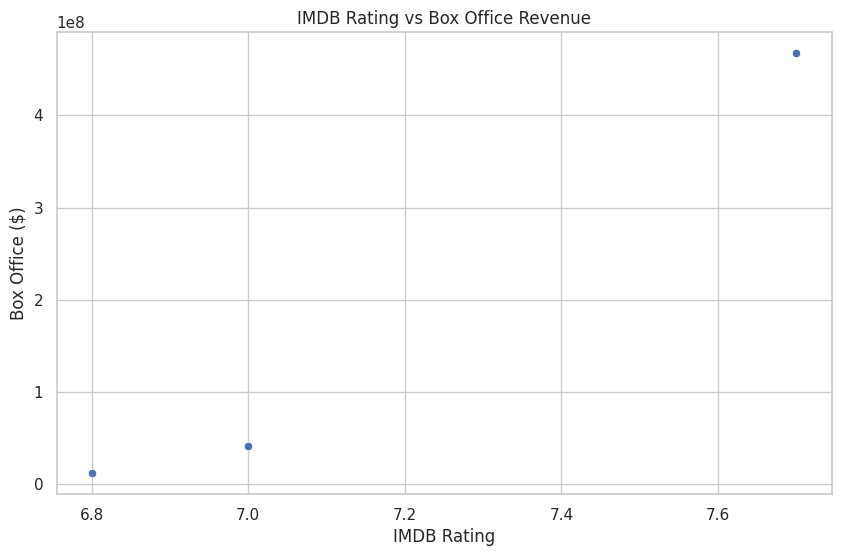

✅ Saved output as CSV: movies.csv


In [26]:
def main():
    # Load box office data
    box_office_df = pd.read_csv('box_office.csv') # Change to csv filename
    box_office_df.rename(columns={'Gross': 'BoxOffice'}, inplace=True)
    summarize_data(box_office_df)

    # Random sample of movies
    movie_title_years = (
        box_office_df[['Title', 'Year']]
        .dropna()
        .drop_duplicates()
        .sample(n=3)    # Change the value of n to determine the number of movies collected
        .values.tolist()
    )

    # Fetch ratings
    ratings_dict = fetch_ratings(movie_title_years)

    if not ratings_dict:
        print("❌ No IMDB ratings were successfully scraped. Exiting.")
        return

    # Create ratings dataframe
    ratings_df = pd.DataFrame([
        {'Title': title, 'IMDB_Score': score} for title, score in ratings_dict.items()
    ])
    summarize_data(ratings_df)

    # Merge and clean
    merged_df = pd.merge(box_office_df, ratings_df, on='Title', how='left')
    clean_df = clean_numeric_data(merged_df)
    summarize_data(clean_df)

    summary_stats(clean_df)
    analyze_correlation(clean_df)
    plot_rating_vs_boxoffice(clean_df)

    # Outputs
    if output_format == "json":
        clean_df.to_json("movies.json", orient="records", lines=True)
        print("✅ Saved output as JSON: movies.json")

    elif output_format == "csv":
        clean_df.to_csv("movies.csv", index=False)
        print("✅ Saved output as CSV: movies.csv")

    elif output_format == "sql":
        conn = sqlite3.connect("movies.db")
        clean_df.to_sql("movies", conn, if_exists="replace", index=False)
        conn.close()
        print("✅ Saved output as SQLite DB: movies.db")

    else:
        print("⚠️ Unknown format selected.")


if __name__ == '__main__':
    main()
